# Introduction

World Health Organization (WHO) mengatakan bahwa sekitar 17,9 juta orang meninggal karena penyakit jantung pada tahun 2020, menjadikannya salah satu penyebab kematian tertinggi di dunia.

Gagal jantung adalah salah satu jenis penyakit jantung yang paling umum. Kondisi ini terjadi ketika jantung tidak dapat memompa darah dengan cukup untuk memenuhi kebutuhan tubuh. Beberapa penyebab gagal jantung termasuk penyakit arteri koroner, diabetes, dan hipertensi.

Dokter dapat menemukan gagal jantung lebih awal dan memberikan pengobatan yang tepat untuk pasien, yang meningkatkan peluang mereka untuk bertahan hidup dan menjalani kehidupan yang lebih sehat.

Objective yang ingin dicapai dari kasus ini adalah untuk memprediksi apakah pasien akan mengalami gagal jantung dalam waktu 5 tahun setelah diagnosis

Kelompok kami terdiri dari 3 orang: -MONICA BELINDA -YUSRAINI ASRA -ARYA RAHMAN

# Import Libraries

In [2]:
# Data Wrangling
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.integrate import simps

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from pickle import dump,load

# Settings
pd.set_option("display.max.columns",None)
%matplotlib inline
mpl.style.use(["ggplot"])

# Data Loading

Import *heart_failure_clinical_records_dataset.csv* as *df* 

In [3]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.columns = df.columns.str.lower()
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Check the shape of the dataset, which has 299 rows and 13 columns.

In [4]:
print(f"Number of Rows\t\t: {df.shape[0]}")
print(f"Number of Columns\t: {df.shape[1]}")

Number of Rows		: 299
Number of Columns	: 13


# Data Cleaning

In order to make things clearer, let's rename *0* to *Survived* and *1* to *Dead* on *death_event* column.

In [5]:
df["death_event"] = df["death_event"].replace({0:"Survived",1:"Dead"})

Get a better understanding of the dataset by looking at every variable's type, null values, number of unique values, and sample.

In [6]:
pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage":df.isnull().sum().values / len(df) * 100,
    "unique":[df[i].nunique() for i in df.columns],
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null",ascending=False)

,type,null,null_percentage,unique,sample
age,float64,0,0.0,47,55.0
anaemia,int64,0,0.0,2,0
creatinine_phosphokinase,int64,0,0.0,208,131
diabetes,int64,0,0.0,2,1
ejection_fraction,int64,0,0.0,17,60
high_blood_pressure,int64,0,0.0,2,1
platelets,float64,0,0.0,176,337000.0
serum_creatinine,float64,0,0.0,40,1.18
serum_sodium,int64,0,0.0,27,146
sex,int64,0,0.0,2,1


Specify which variables are numerical and categorical.

In [7]:
cat_cols = ["anaemia","diabetes","high_blood_pressure","sex","smoking","death_event"]
num_cols = [i for i in df.columns if i not in cat_cols]

print(f"Categorical Columns\t({len(cat_cols)})\t: {list(cat_cols)}")
print(f"Numerical Columns\t({len(num_cols)})\t: {list(num_cols)}")

Categorical Columns	(6)	: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']
Numerical Columns	(7)	: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


In order to make things easier, let's create functions that will help us to detect and show outliers from our dataset.

In [8]:
def create_boxplot(nrows,ncols,data,x_axis):

    fig,ax = plt.subplots(nrows,ncols,figsize=(25,15),dpi=200)

    n = 0
    for nrow in range(nrows):
        for ncol in range(ncols):
            sns.boxplot(data=data,x=x_axis[n],ax=ax[nrow,ncol])
            ax[nrow,ncol].set_title(f"Box Plot of {x_axis[n]}")
            n += 1
            if n == len(x_axis):
                break

    for ax in ax.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

def find_outlier(data):
    q1 = np.quantile(data,0.25)
    q3 = np.quantile(data,0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)
    
    outlier = []
    for i in data:
        if (i < min_iqr) or (i > max_iqr):
            outlier.append(i)
    
    return outlier

def show_outlier(data,variables):
    return pd.DataFrame({
        "outliers":[len(j) for j in [find_outlier(data[i]) for i in variables]],
        "percentage":np.array([len(j) for j in [find_outlier(data[i]) for i in variables]]) / len(data) * 100
    }).set_index([variables]).sort_values("outliers",ascending=False)

Apply the functions that we just made earlier to our dataset. As it can be seen, there's a lot of outliers.

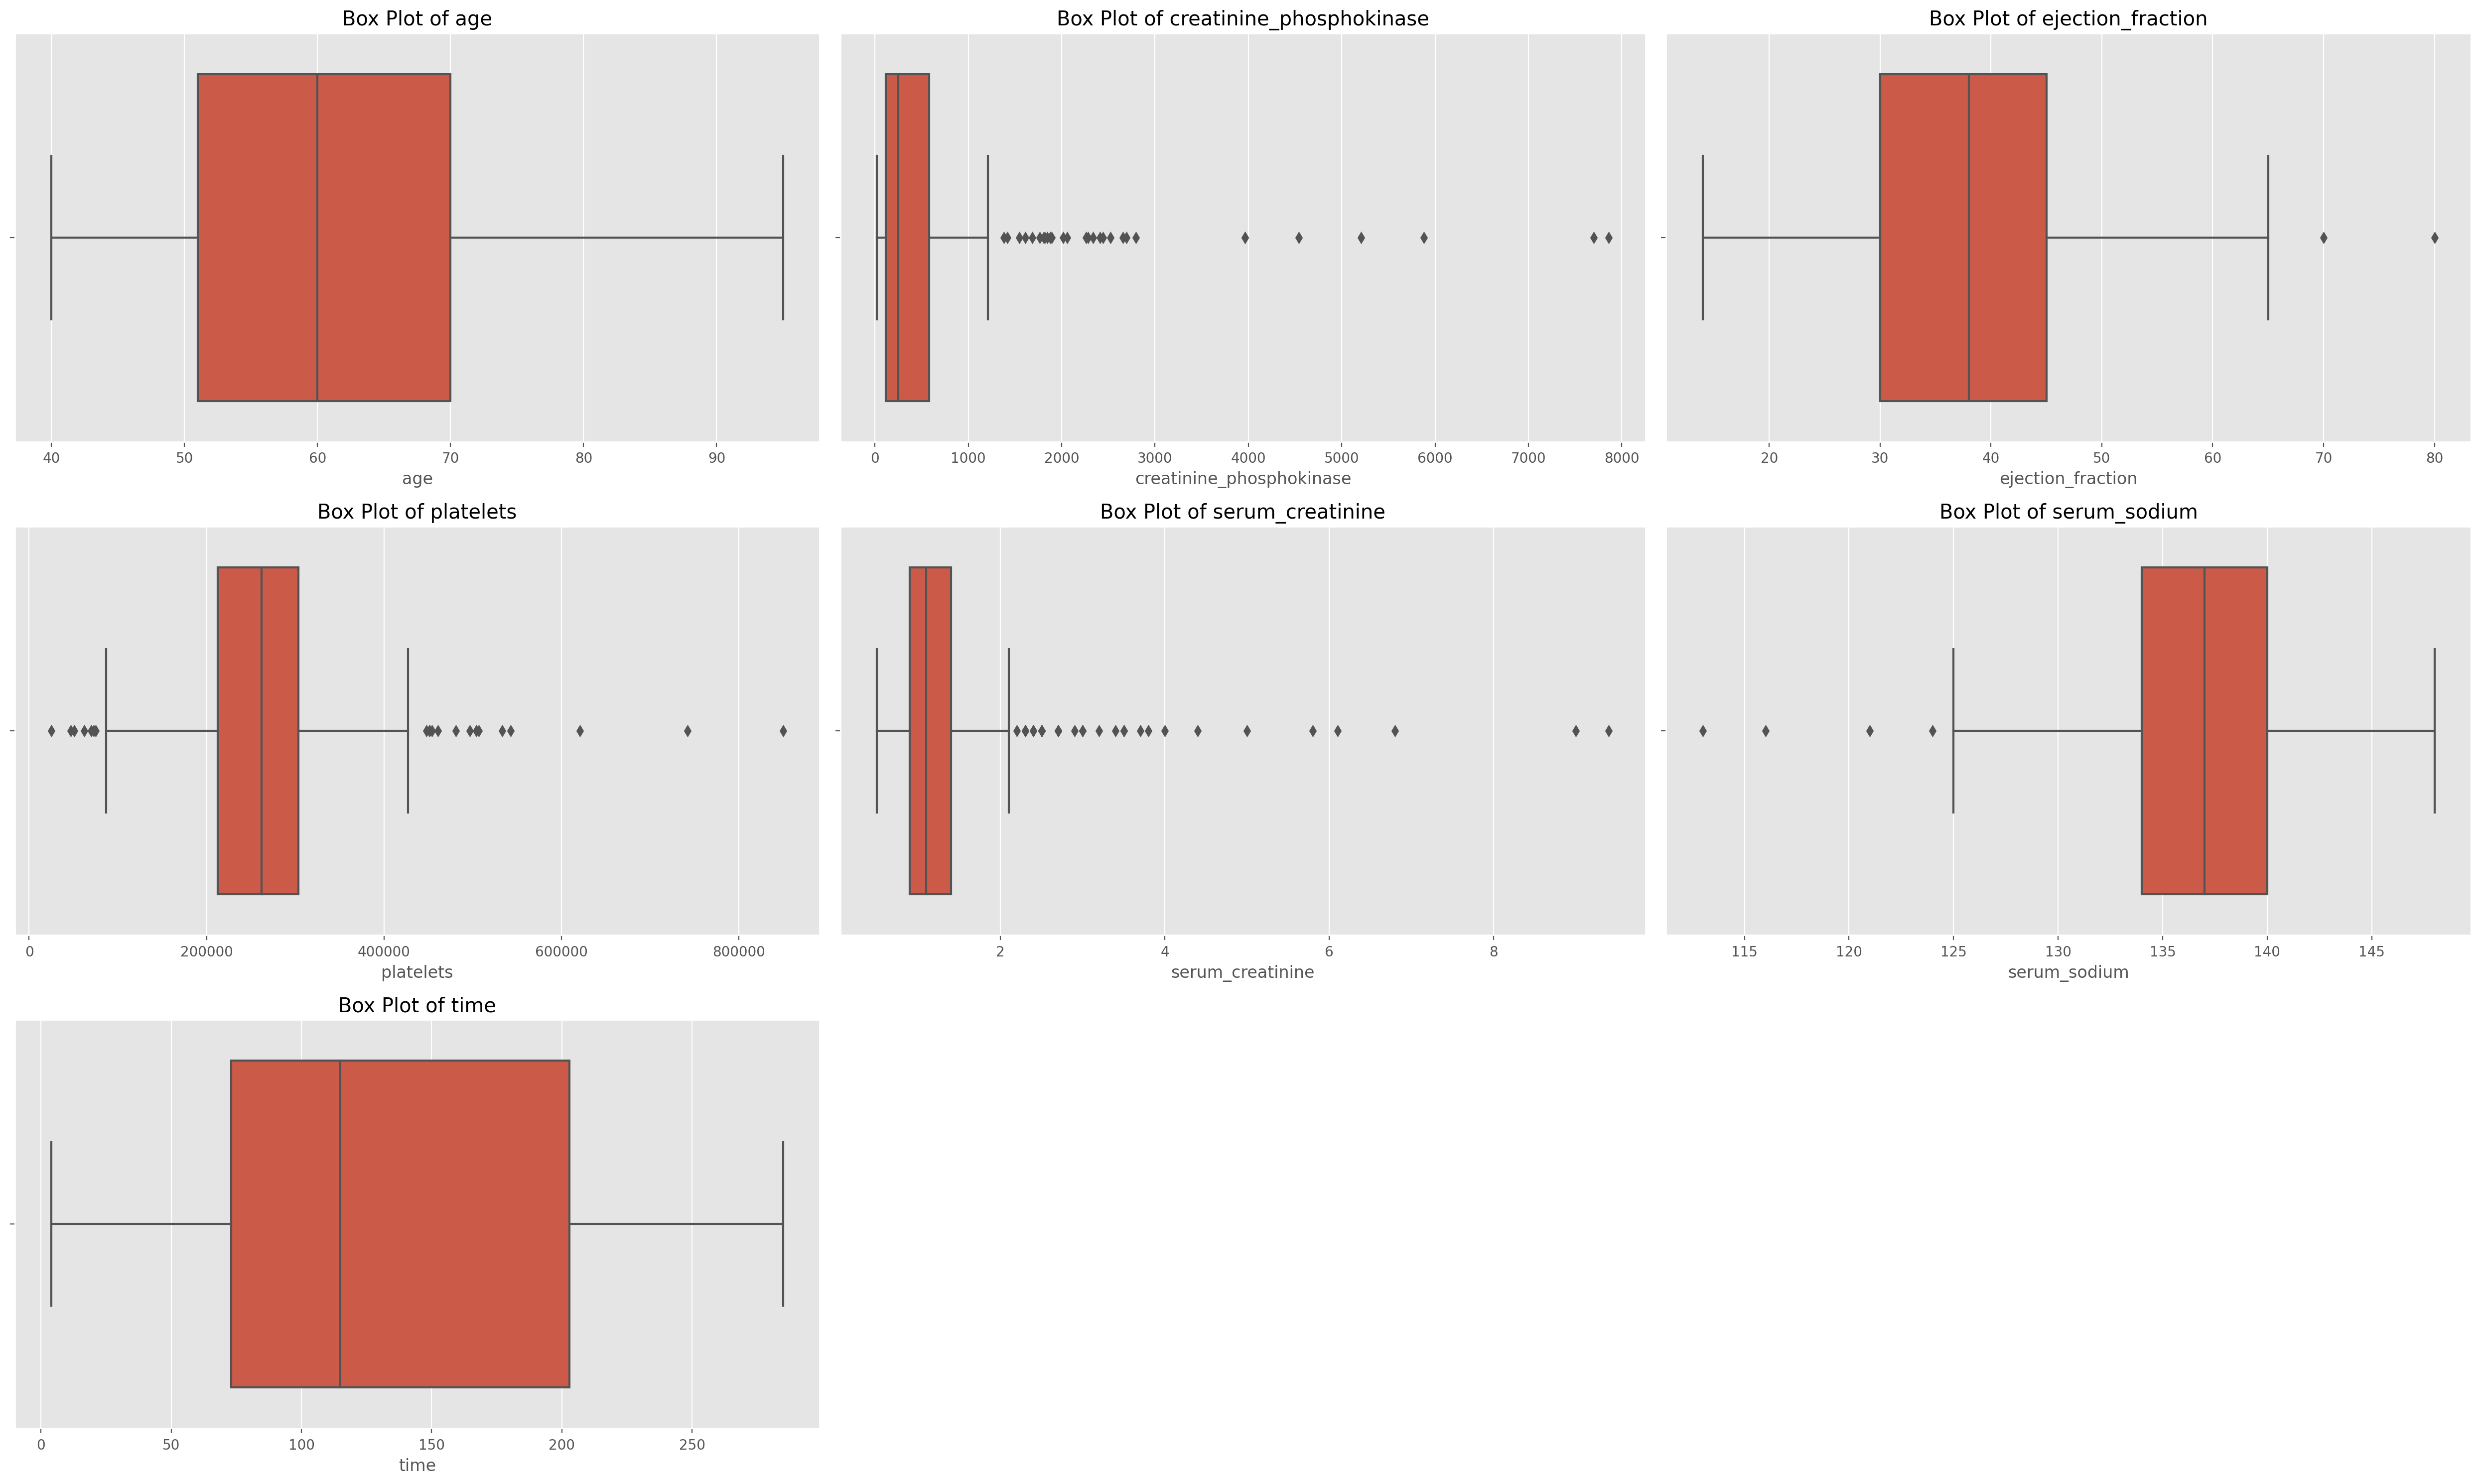

,outliers,percentage
creatinine_phosphokinase,29,9.698997
serum_creatinine,29,9.698997
platelets,21,7.023411
serum_sodium,4,1.337793
ejection_fraction,2,0.668896
age,0,0.000000
time,0,0.000000


In [9]:
create_boxplot(3,3,df,num_cols)
show_outlier(df,num_cols)

Let's remove outliers on every variable using the IQR method.

In [10]:
for i in num_cols:
    q1 = np.quantile(df[i],0.25)
    q3 = np.quantile(df[i],0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)

    df = df[(df[i] >= min_iqr) & (df[i] <= max_iqr)]

Let's check for the second time. As it can be seen, there's only a few outliers left, so we can move on to the next step.

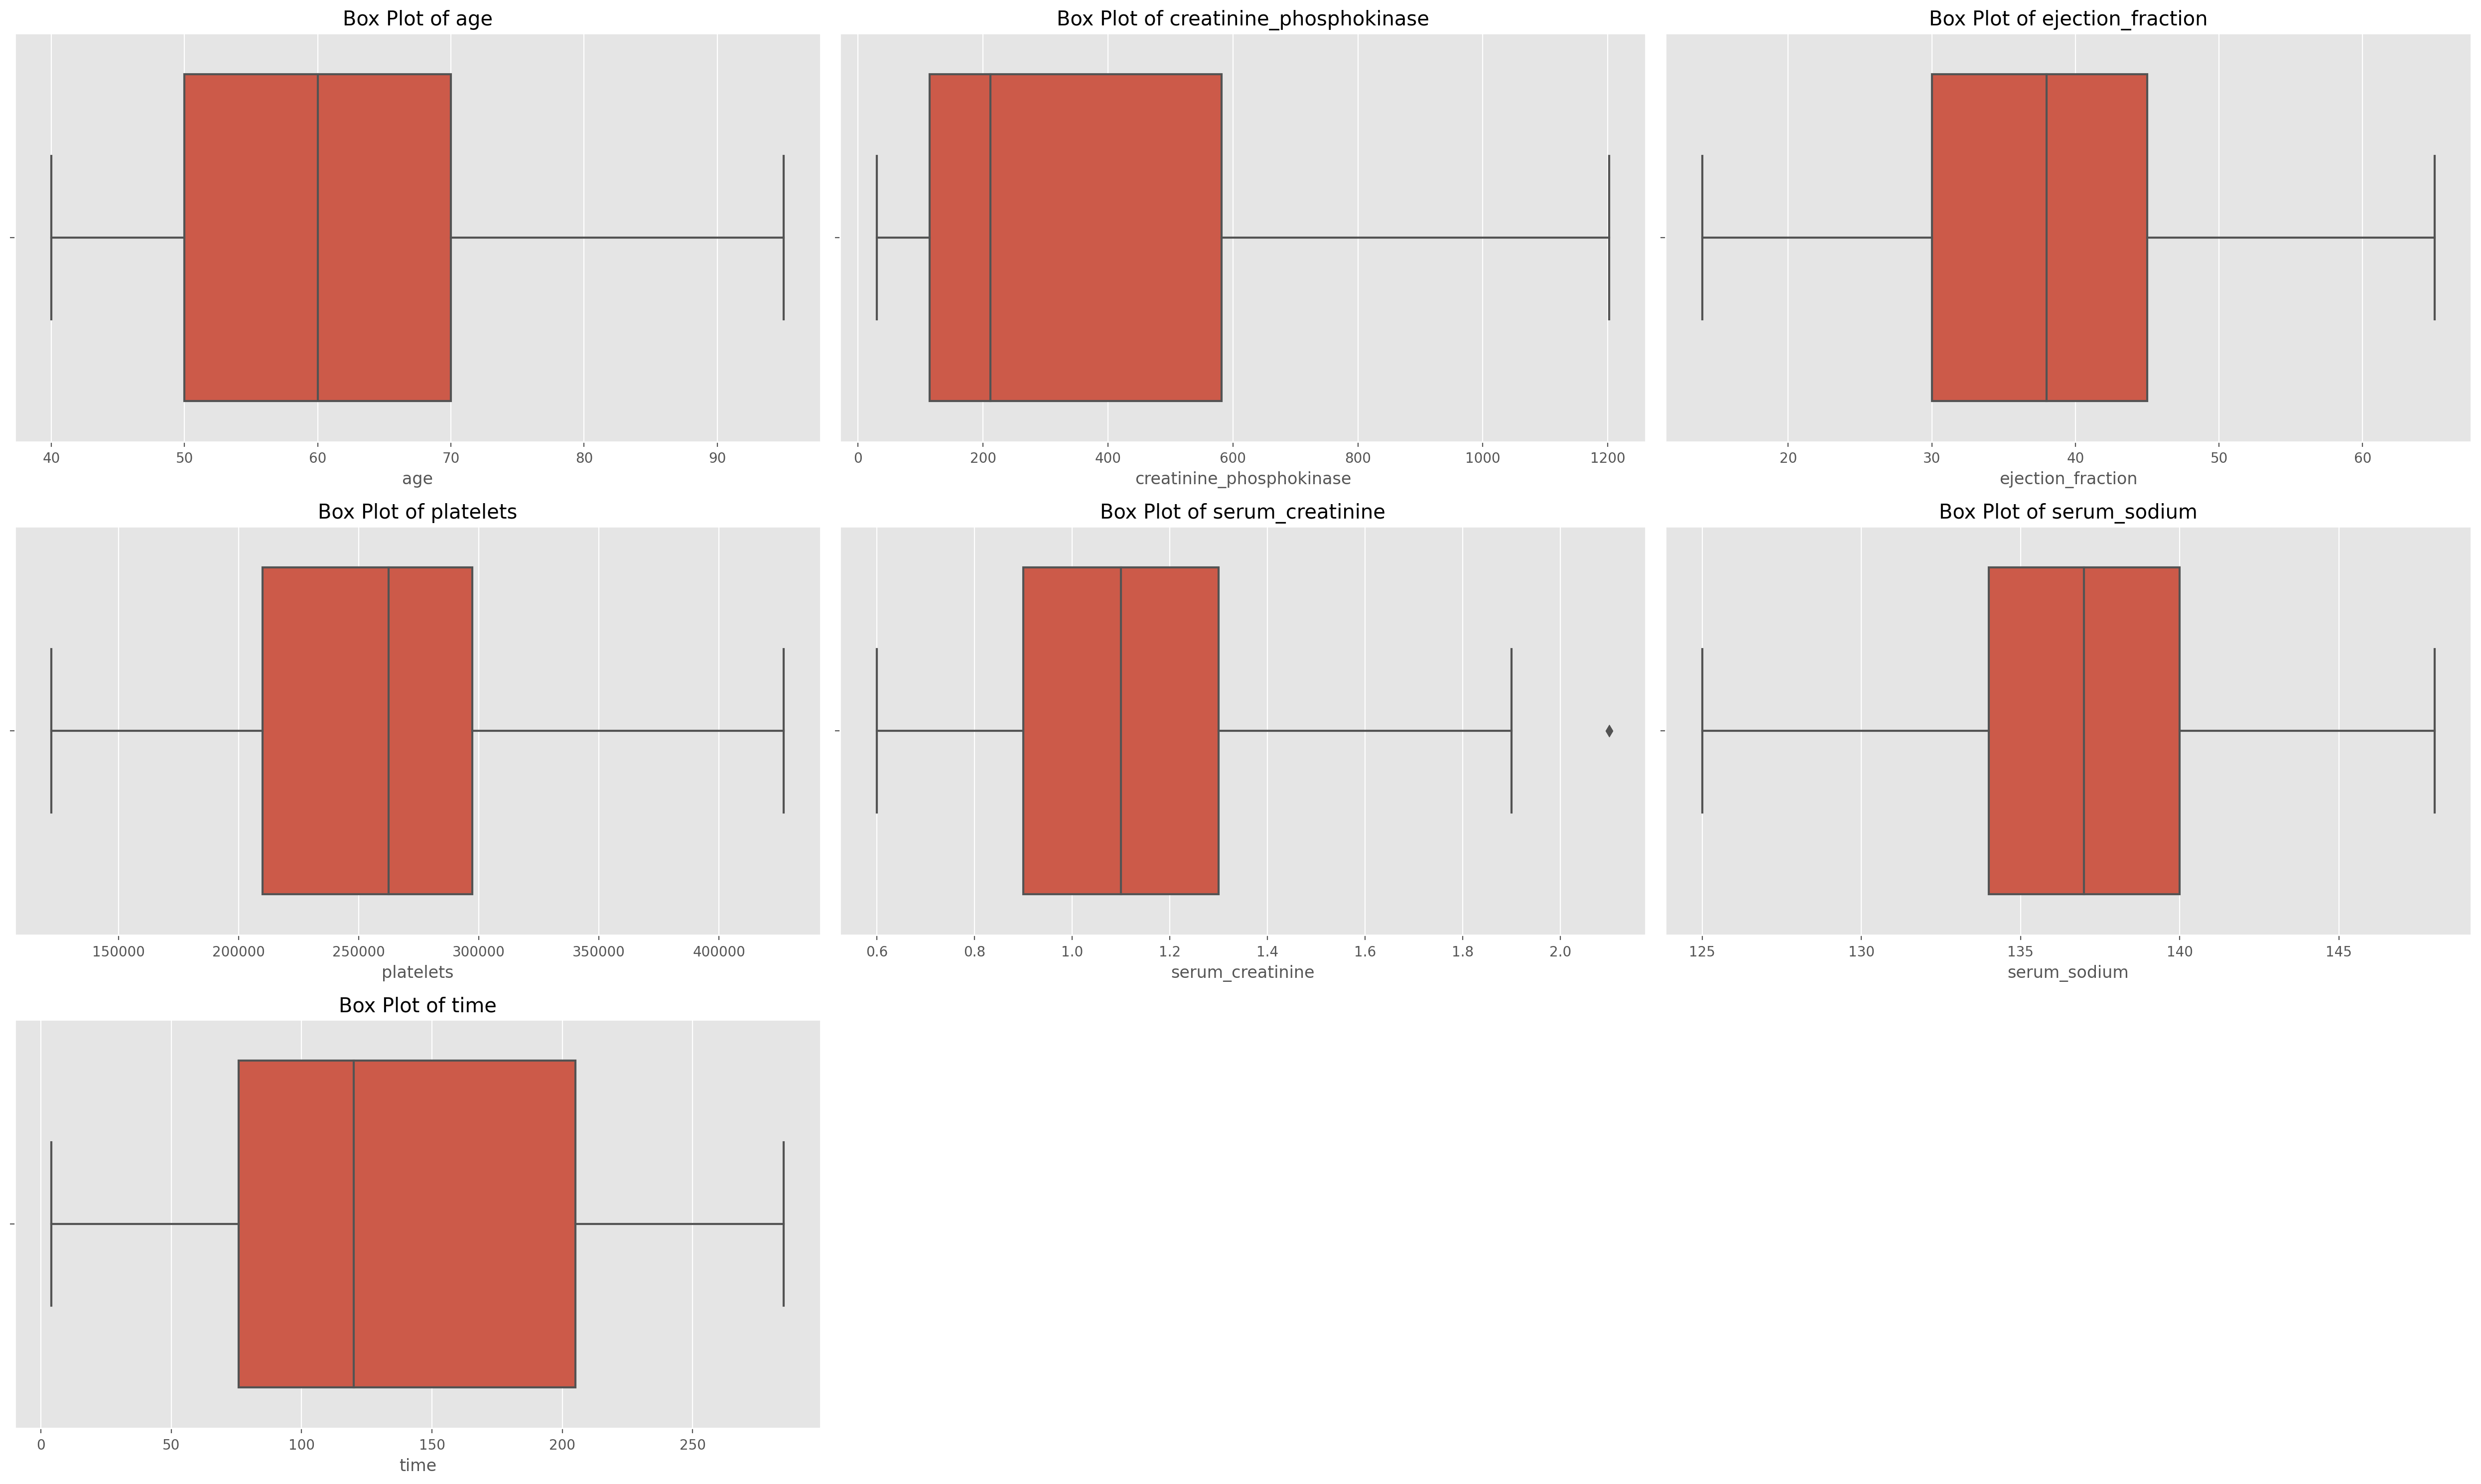

,outliers,percentage
serum_creatinine,3,1.339286
age,0,0.000000
creatinine_phosphokinase,0,0.000000
ejection_fraction,0,0.000000
platelets,0,0.000000
serum_sodium,0,0.000000
time,0,0.000000


In [12]:
create_boxplot(3,3,df,num_cols)
show_outlier(df,num_cols)

# Data Exploration

Find the correlation between features and target, which is *death_event*. As it can be seen, the *time* feature has the most influence on *death_event*.

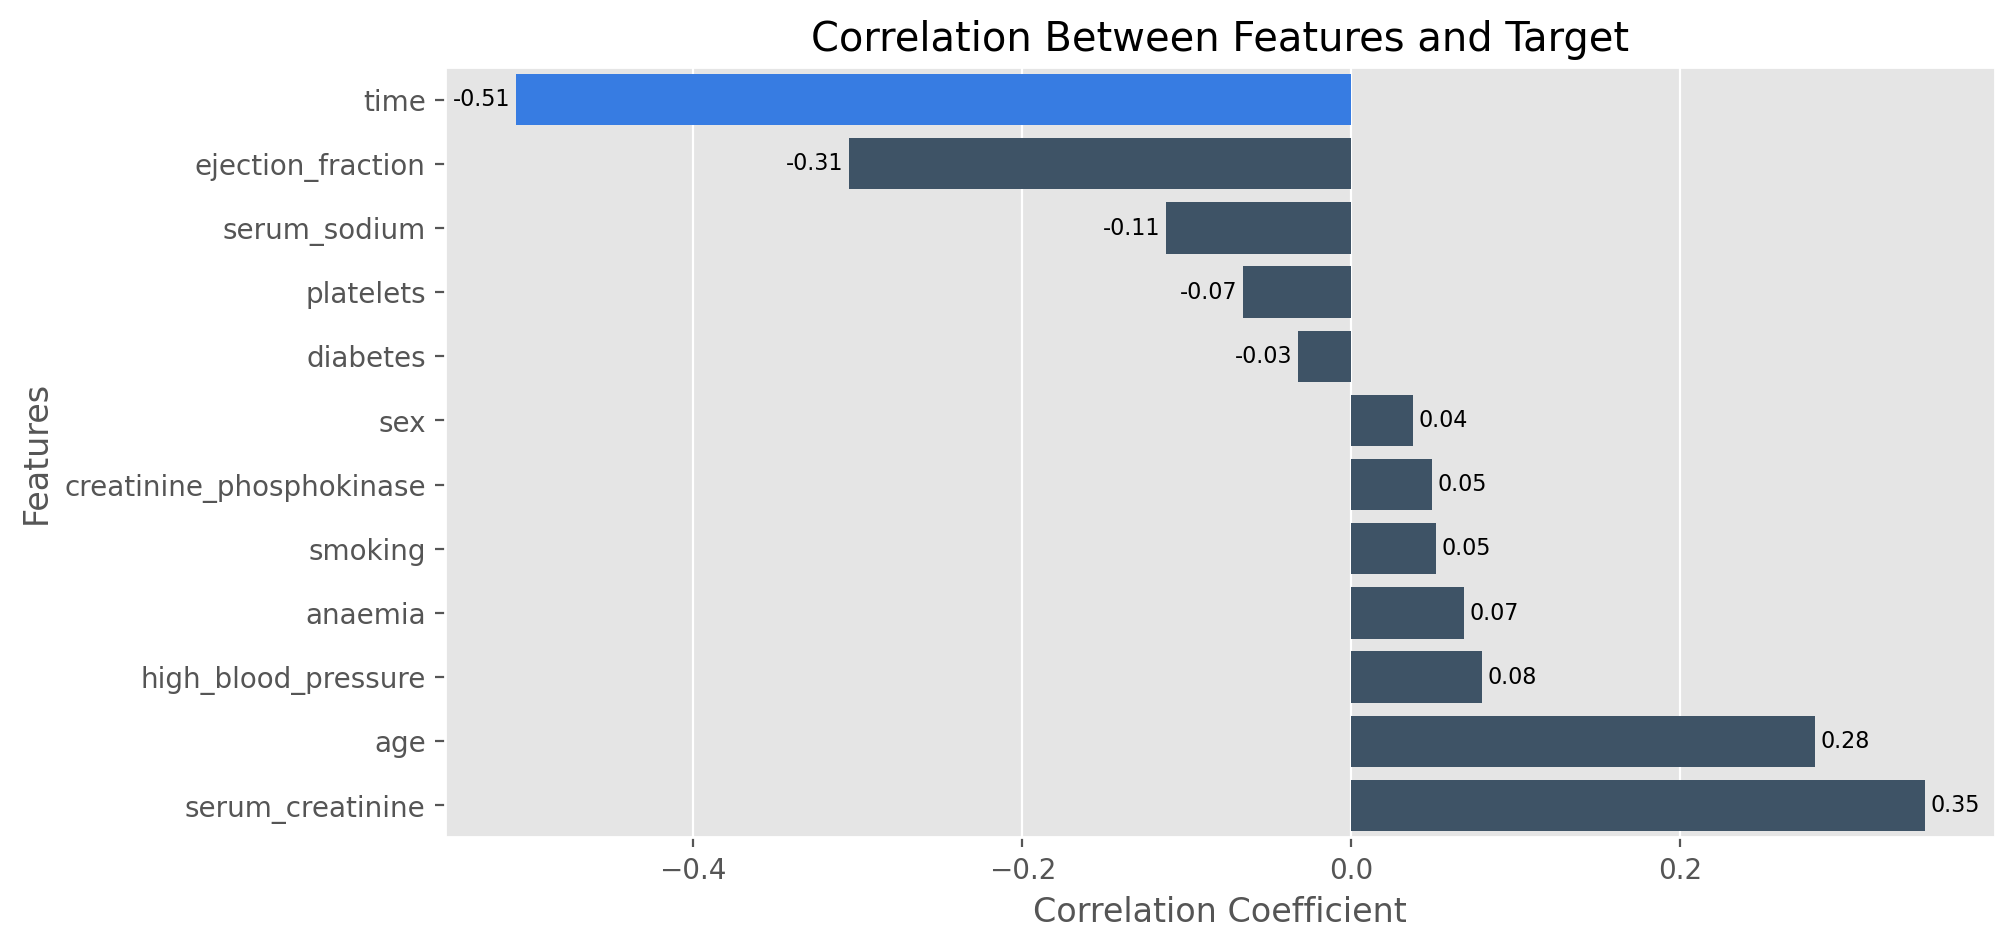

In [13]:
corr = pd.get_dummies(df).iloc[:,:-1].corr()[["death_event_Dead"]].iloc[:-1].sort_values("death_event_Dead")

plt.figure(figsize=(10,5),dpi=200)
ax = sns.barplot(
    data=corr,
    x=corr.death_event_Dead,
    y=corr.index,
    palette=["#1a76ff" if i == np.max(abs(corr.death_event_Dead)) else "#37536d" for i in abs(corr.death_event_Dead)]
)

for container in ax.containers:
    ax.bar_label(container,fmt="%.2f",color="black",fontsize=8,padding=2)

plt.title("Correlation Between Features and Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()

The *time* feature has a negative relationship with *death_event*, which means the longer the follow-up period is, the less likely the patient will die.

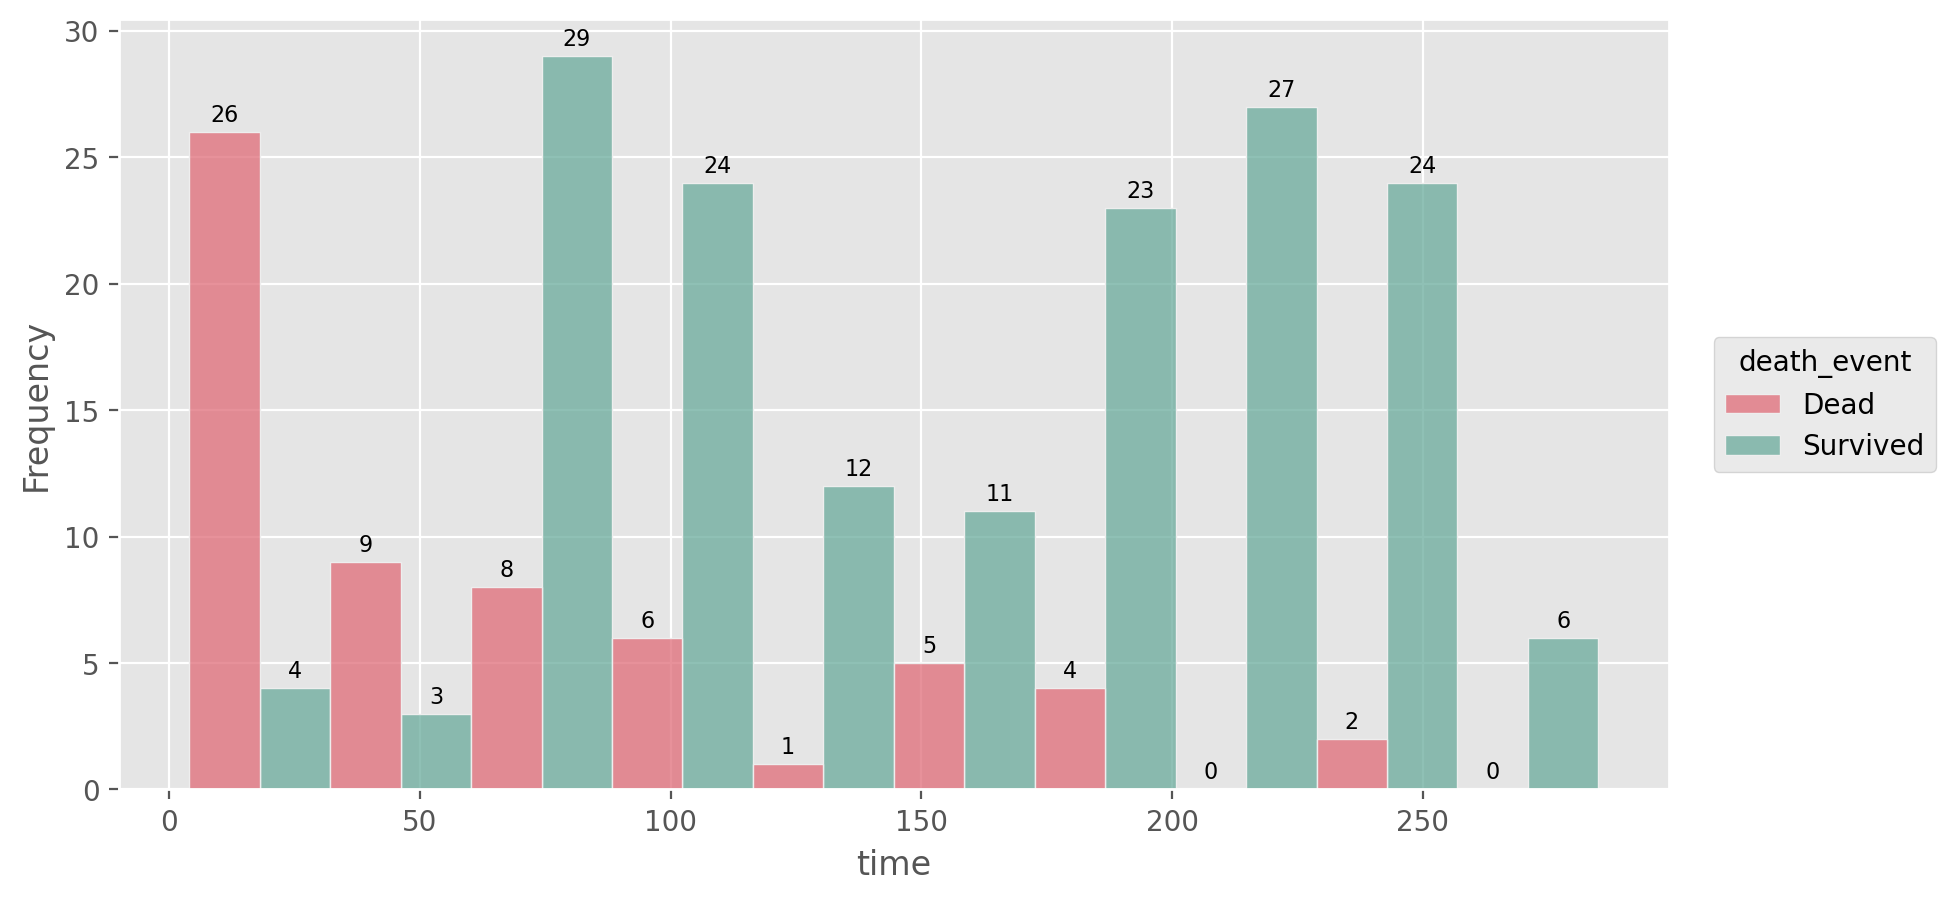

In [14]:
plt.figure(figsize=(10,5),dpi=200)
ax = sns.histplot(df,x="time",hue="death_event",palette=["#E06C78","#6AAB9C"],multiple="dodge",bins=10)

for container in ax.containers:
    ax.bar_label(container,color="black",fontsize=8,padding=2)

sns.move_legend(ax,loc="center left",bbox_to_anchor=(1.02,0.5))
plt.ylabel("Frequency")
plt.show()

Now, let's take a look at the two features that have the most influences after *time*, which are *ejection_fraction* and *serum_creatinine*. The higher the *ejection_fraction* is and the lower the *serum_creatinine* is, the more likely the patient will survive. In order to simplify things, we'll separate *ejection_fraction* and *serum_creatinine* into 2 categories, which are *greater than or equal to* and *less than* the averages.

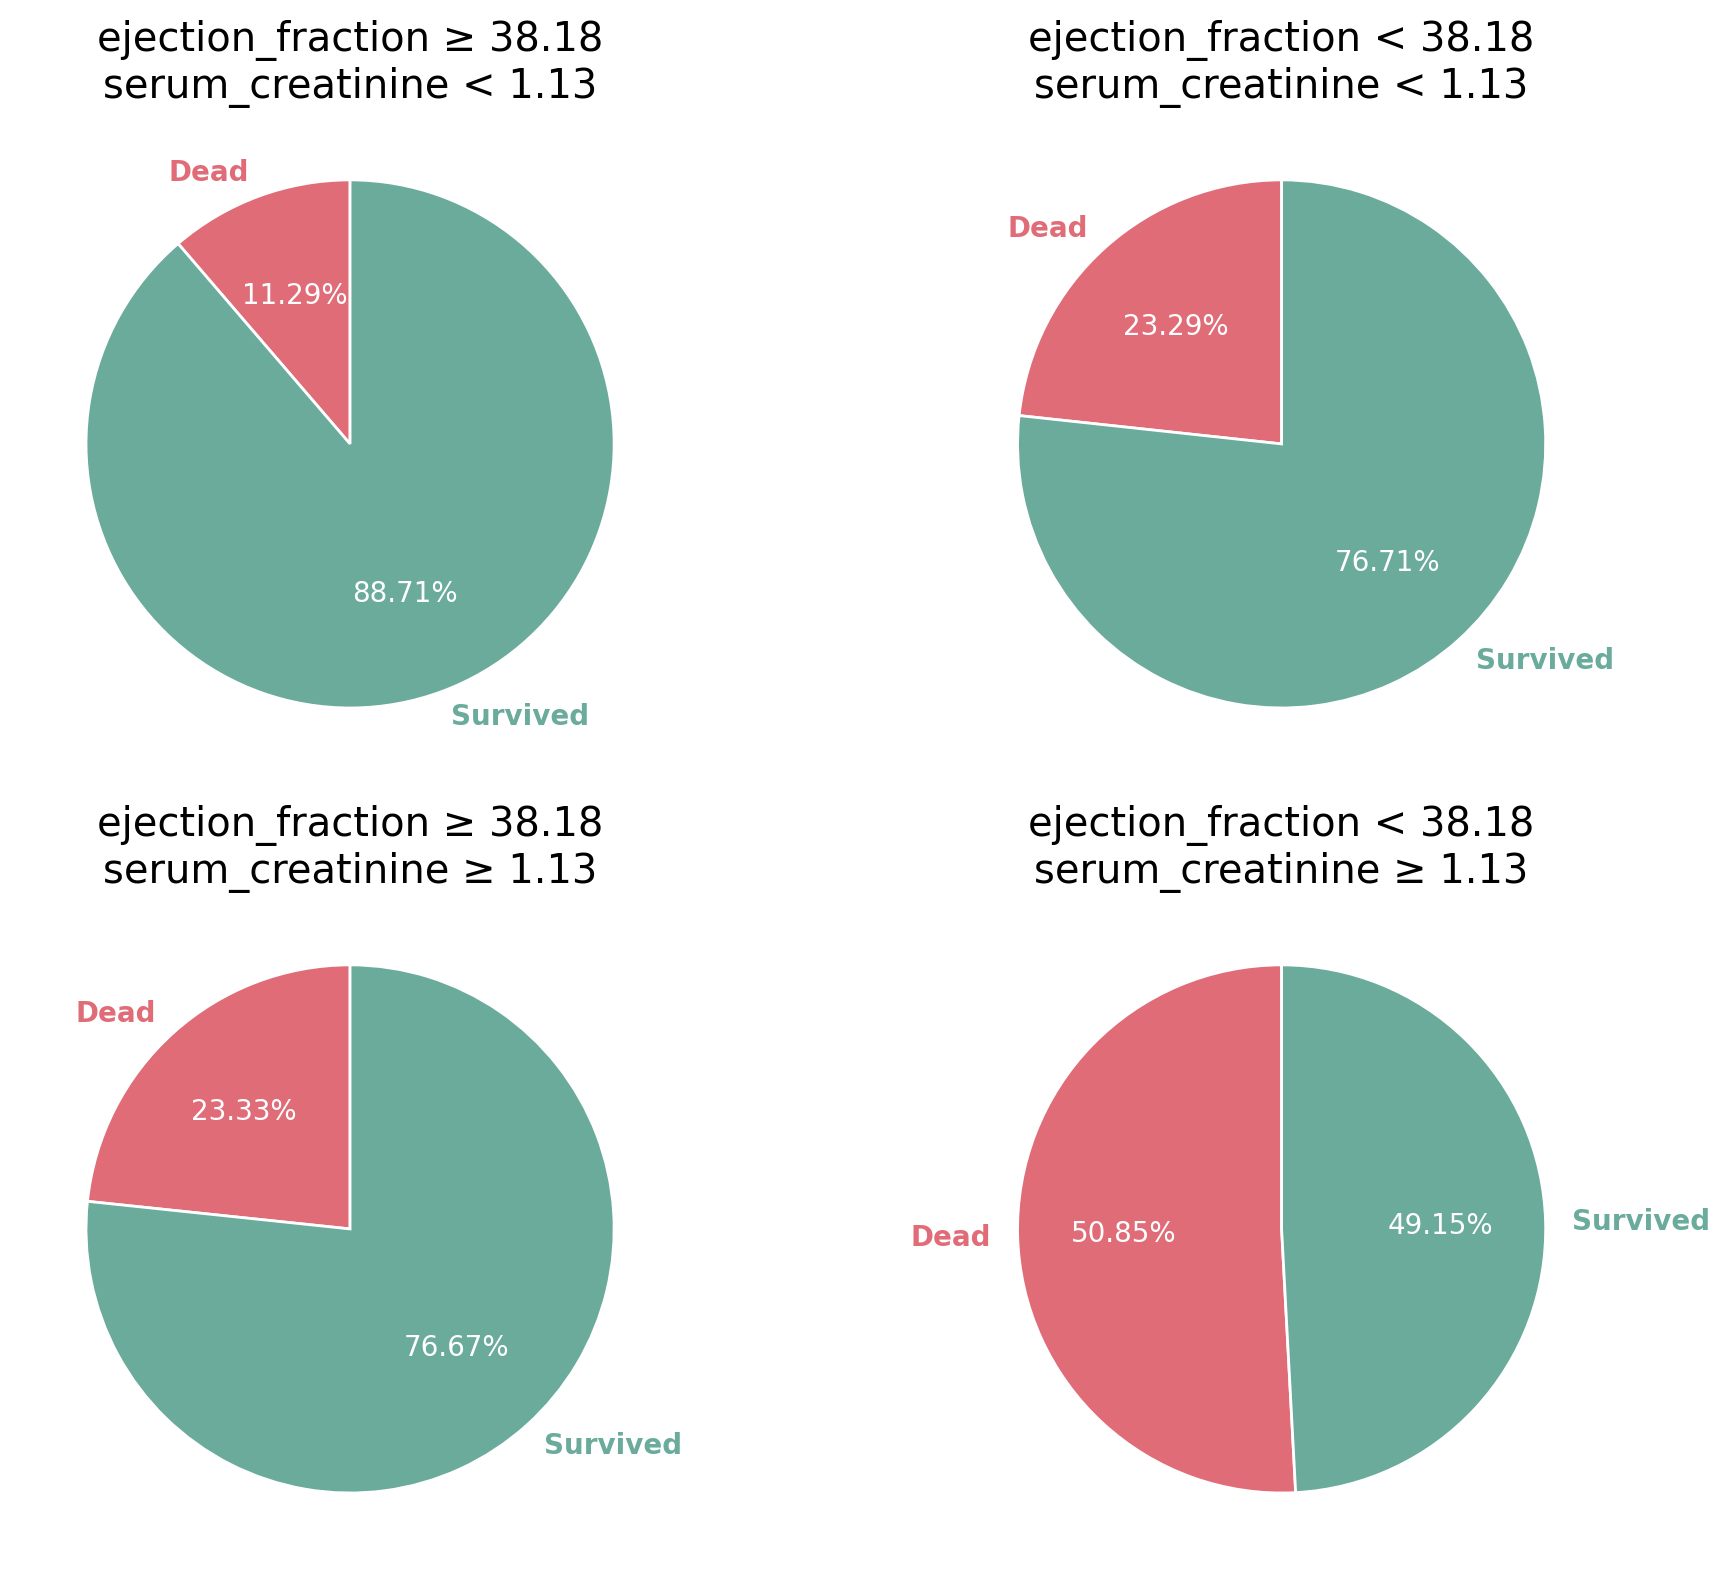

In [15]:
first = df[
    (df["ejection_fraction"] >= np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] < np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

second = df[
    (df["ejection_fraction"] < np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] < np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

third = df[
    (df["ejection_fraction"] >= np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] >= np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

fourth = df[
    (df["ejection_fraction"] < np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] >= np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

ejection_fraction_and_serum_creatinine = [first,second,third,fourth]
titles = [
    f"ejection_fraction ≥ {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine < {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction < {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine < {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction ≥ {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine ≥ {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction < {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine ≥ {round(np.mean(df['serum_creatinine']),2)}",
]

nrows,ncols = 2,2
fig,ax = plt.subplots(nrows,ncols,figsize=(10,8),dpi=200,sharex=True,sharey=True)

n = 0
for nrow in range(nrows):
    for ncol in range(ncols):
        patches,texts,pcts = ax[nrow,ncol].pie(
            ejection_fraction_and_serum_creatinine[n].age,
            labels=ejection_fraction_and_serum_creatinine[n].index,
            startangle=90,
            colors=["#E06C78","#6AAB9C"],
            autopct="%.2f%%",
            wedgeprops={"linewidth":1.0,"edgecolor":"white"}
        )

        ax[nrow,ncol].set_title(titles[n])

        n += 1

        for index,patch in enumerate(patches):
            texts[index].set_color(patch.get_facecolor())

        plt.setp(pcts,color="white")
        plt.setp(texts,fontweight=600)

plt.tight_layout()
plt.show()



Berdasarkan  American Heart Association, sebuah organisasi nirlaba di Amerika Serikat, normal *ejection_fraction* adalah sekitar 50% hingga 75%. Dari semua 224 pasien (after removing outliers), hanya 20,98% dari mereka yang memiliki *ejection_fraction* normal(s).

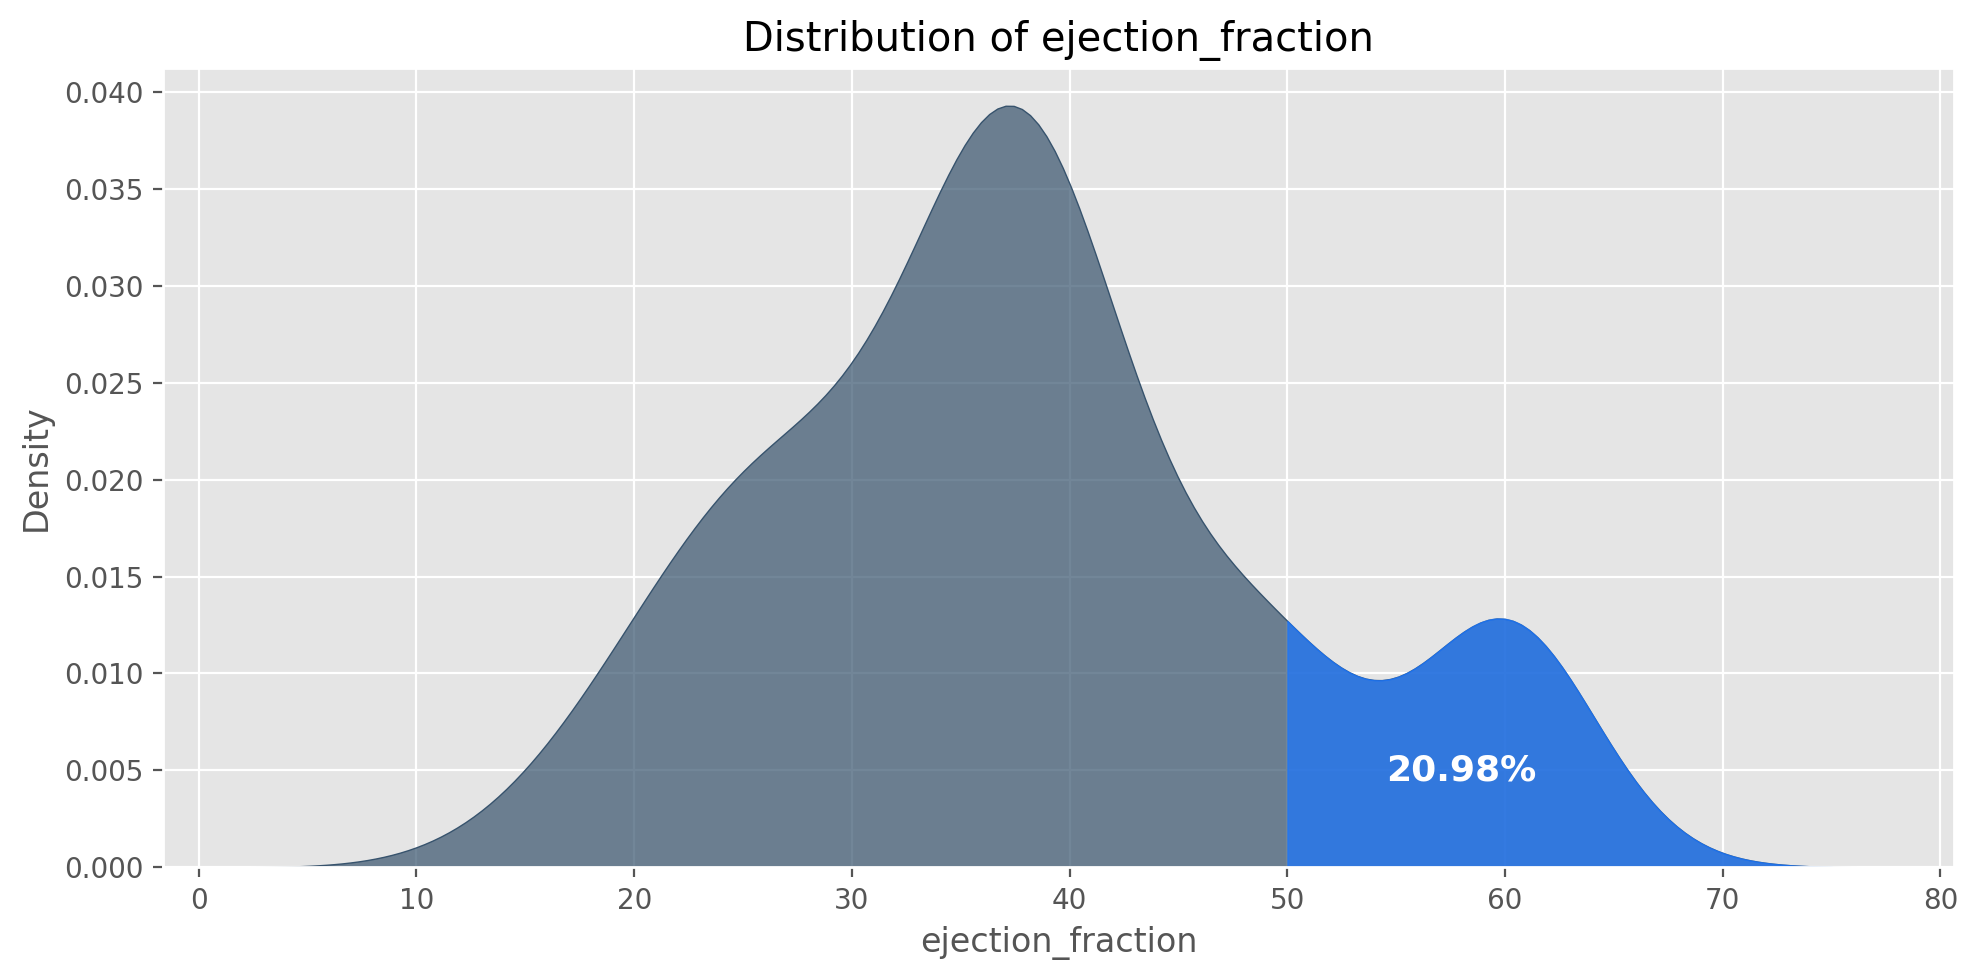

In [16]:
fig,ax = plt.subplots(figsize=(10,5),dpi=200)

kde_ejection_fraction = sns.kdeplot(ax=ax,data=df,x="ejection_fraction",color="#37536d",fill=True,alpha=0.7)
xmin,xmax = kde_ejection_fraction.get_xlim()
kde = gaussian_kde(df["ejection_fraction"])
x = np.linspace(xmin,xmax,10_000)
kde_y = kde(x)

x0,y0 = [],[]
for i,j in zip(x,kde_y):
    if (i >= 50) & (i <= 75):
        x0.append(i)
        y0.append(j)
x0,y0 = np.array(x0),np.array(y0)

area0 = round(simps(y0,x0,dx=1) * 100,0)
kde_ejection_fraction.fill_between(x=x0,y1=y0,color="#1a76ff",alpha=0.7)

ax.set_title("Distribution of ejection_fraction")
ax.set_xlim(xmin,xmax)
ax.text(
    x=58,
    y=0.0045,
    s=f"{round(len(df[(df['ejection_fraction'] >= 50) & (df['ejection_fraction'] <= 75)]) / len(df) * 100,2)}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

plt.tight_layout()
plt.show()

sebuah pusat medis akademik non-profit di Amerika Serikat,Mayo Clinic,  menyatakan bahwa kisaran normal untuk *serum_creatinine* untuk pria dewasa adalah 0,74 hingga 1,35 mg/dL, dan untuk wanita dewasa adalah 0,59 hingga 1,04 mg/dL. Sekitar 68,75 % dari 144 pasien laki-laki dan 60% dari 80 pasien perempuan memiliki kisaran ini.

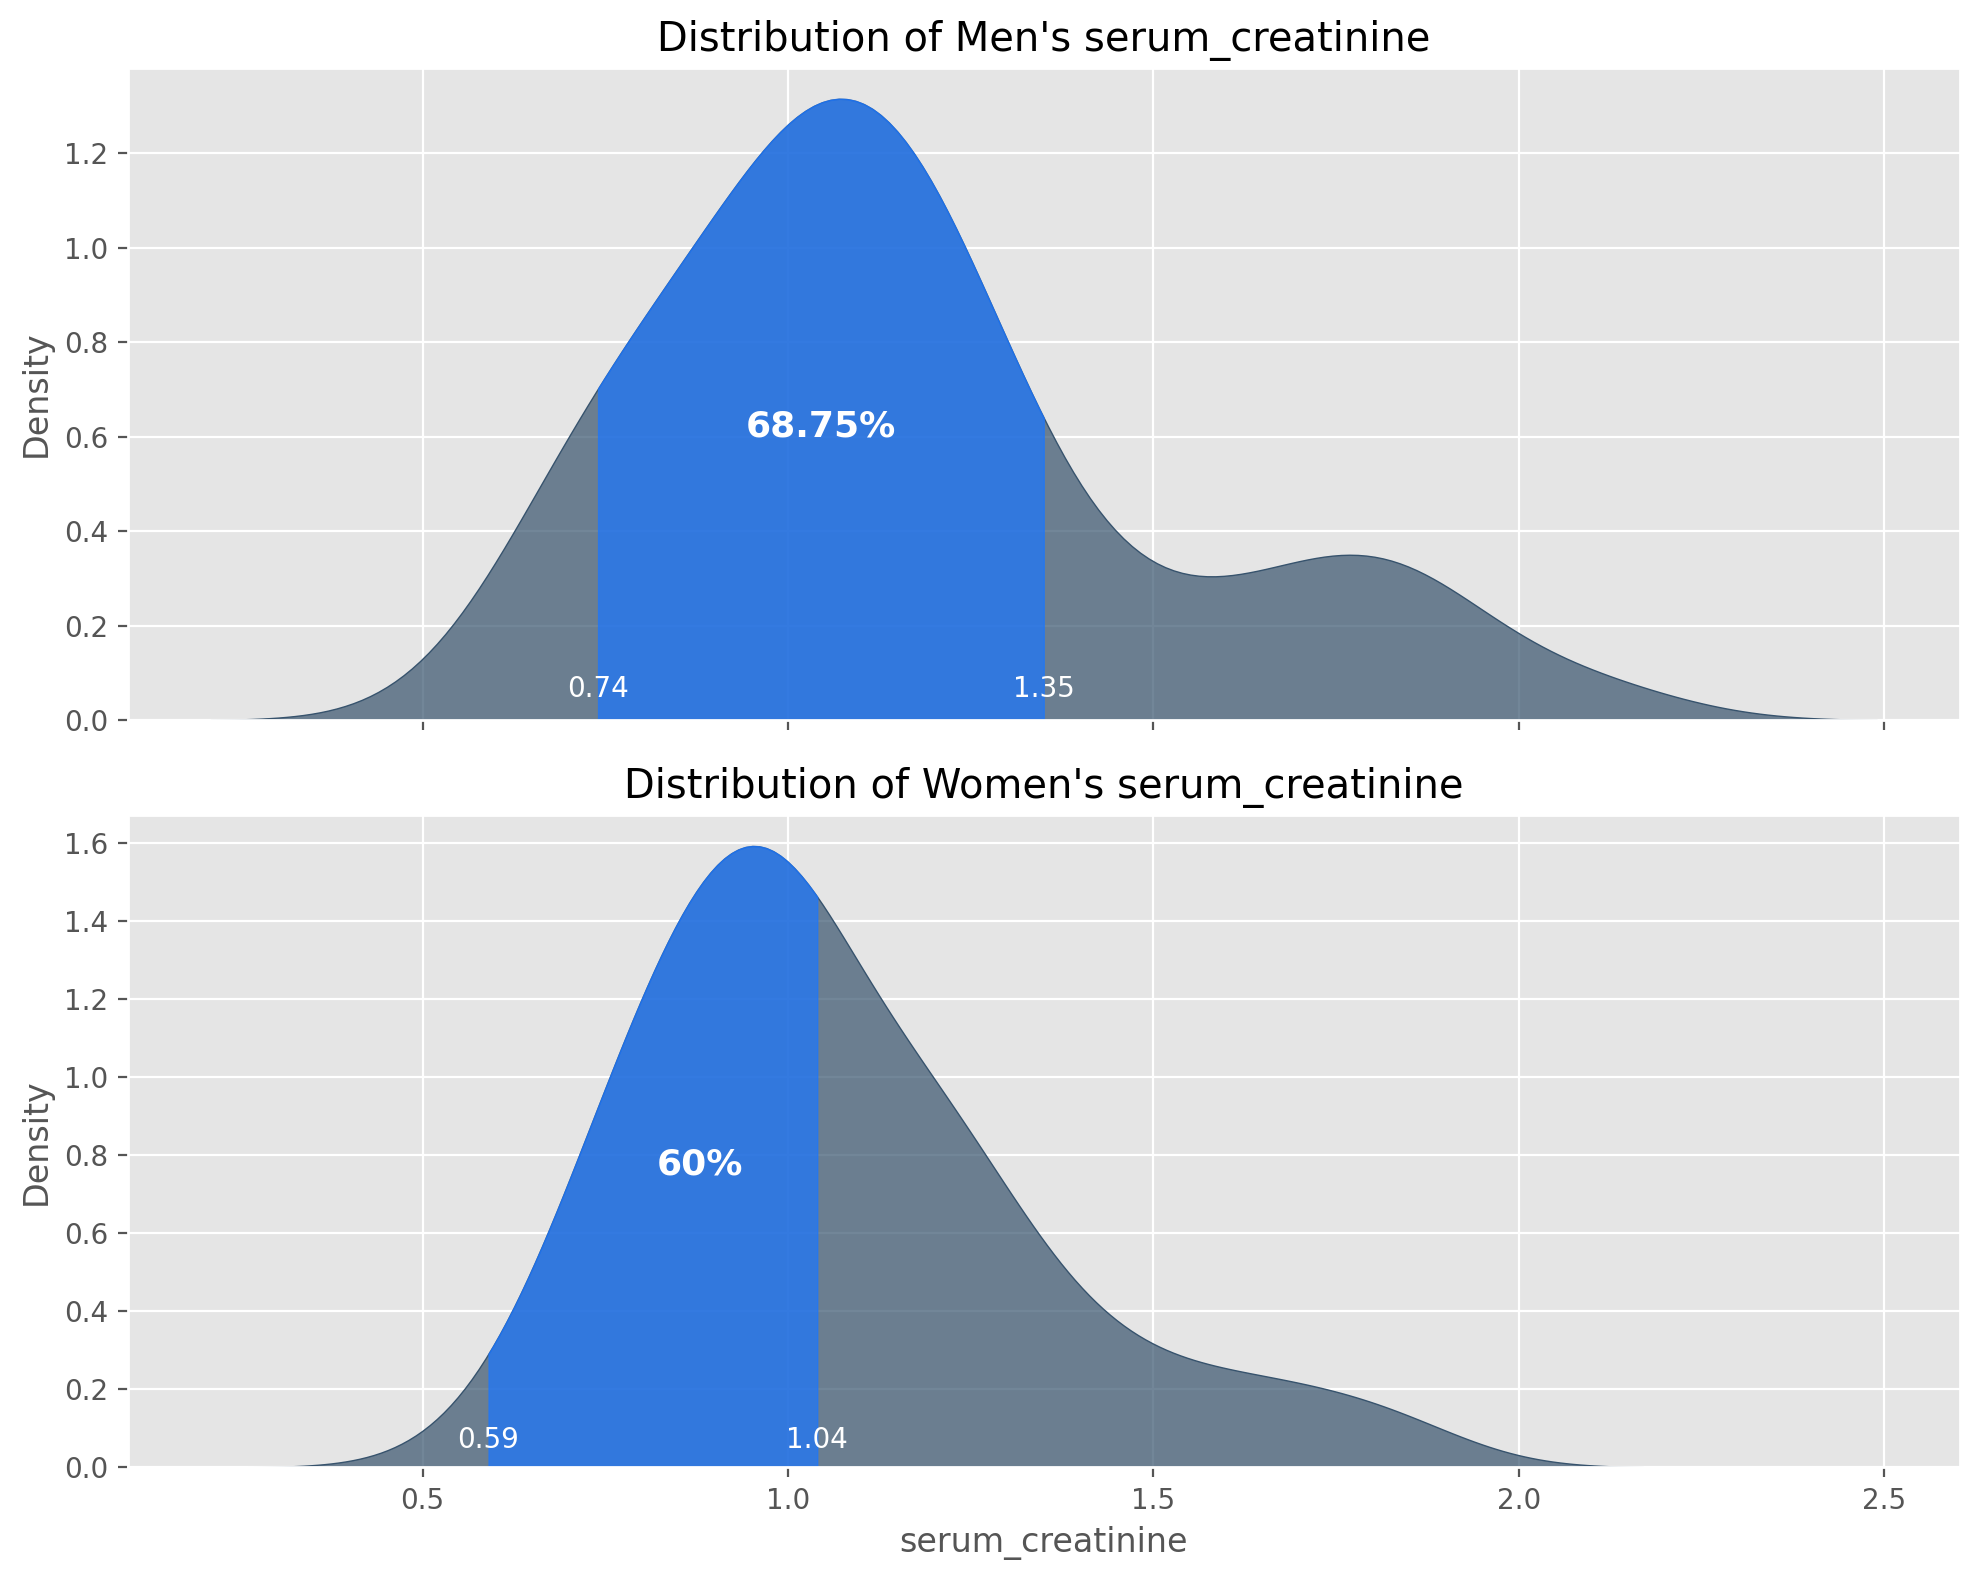

In [17]:
fig,ax = plt.subplots(2,1,figsize=(10,8),dpi=200,sharex=True)

for nrow,lower,upper,sex,title in zip(range(2),[0.74,0.59],[1.35,1.04],[1,0],["Men","Women"]):
    kde_serum_creatinine = sns.kdeplot(ax=ax[nrow],data=df[df["sex"] == sex],x="serum_creatinine",color="#37536d",fill=True,alpha=0.7)
    xmin,xmax = kde_serum_creatinine.get_xlim()
    kde = gaussian_kde(df[df["sex"] == sex]["serum_creatinine"])
    x = np.linspace(xmin,xmax,10_000)
    kde_y = kde(x)

    x0,y0 = [],[]
    for i,j in zip(x,kde_y):
        if (i >= lower) & (i <= upper):
            x0.append(i)
            y0.append(j)
    x0,y0 = np.array(x0),np.array(y0)

    area0 = round(simps(y0,x0,dx=1) * 100,0)
    kde_serum_creatinine.fill_between(x=x0,y1=y0,color="#1a76ff",alpha=0.7)

    ax[nrow].set_title(f"Distribution of {title}'s serum_creatinine")

    for tick in [lower,upper]:
        ax[nrow].text(x=tick,y=0.05,s=tick,horizontalalignment="center",color="white",fontweight=500)

ax[0].text(
    x=0.74 + ((1.35 - 0.74) / 2),
    y=0.6,
    s=f"{len(df[(df['sex'] == 1) & (df['serum_creatinine'] >= 0.74) & (df['serum_creatinine'] <= 1.35)]) / len(df[df['sex'] == 1]) * 100}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

ax[1].text(
    x=0.88,
    y=0.75,
    s=f"{int(len(df[(df['sex'] == 0) & (df['serum_creatinine'] >= 0.59) & (df['serum_creatinine'] <= 1.04)]) / len(df[df['sex'] == 0]) * 100)}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

plt.tight_layout()
plt.show()

# Data Preprocessing

Define features as *X* and target as *y*.

In [18]:
X = df.drop("death_event",axis=1)
y = df["death_event"]

data di bagi menjadi 80% data pelatihan dan 20% data pengujian. *random_state* memastikan bahwa kita memiliki split tes kereta yang sama setiap kali. Nomor benih untuk *random_state* tidak harus 62 karena bisa menjadi nomor apa pun.

In [19]:
random_state = 62
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

print(f"Training dataset\t: {len(X_train)}\t({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)}\t({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 179	(80%)
Testing dataset		: 45	(20%)


kita ambil dua fitur numerik acak untuk memvisualisasikan dataset kita menggunakan plot scatter. Kita dapat melihat bahwa mayoritas dataset milik kelas *Survived* dan sebagian kecil dataset berasal dari kelas *Dead*.

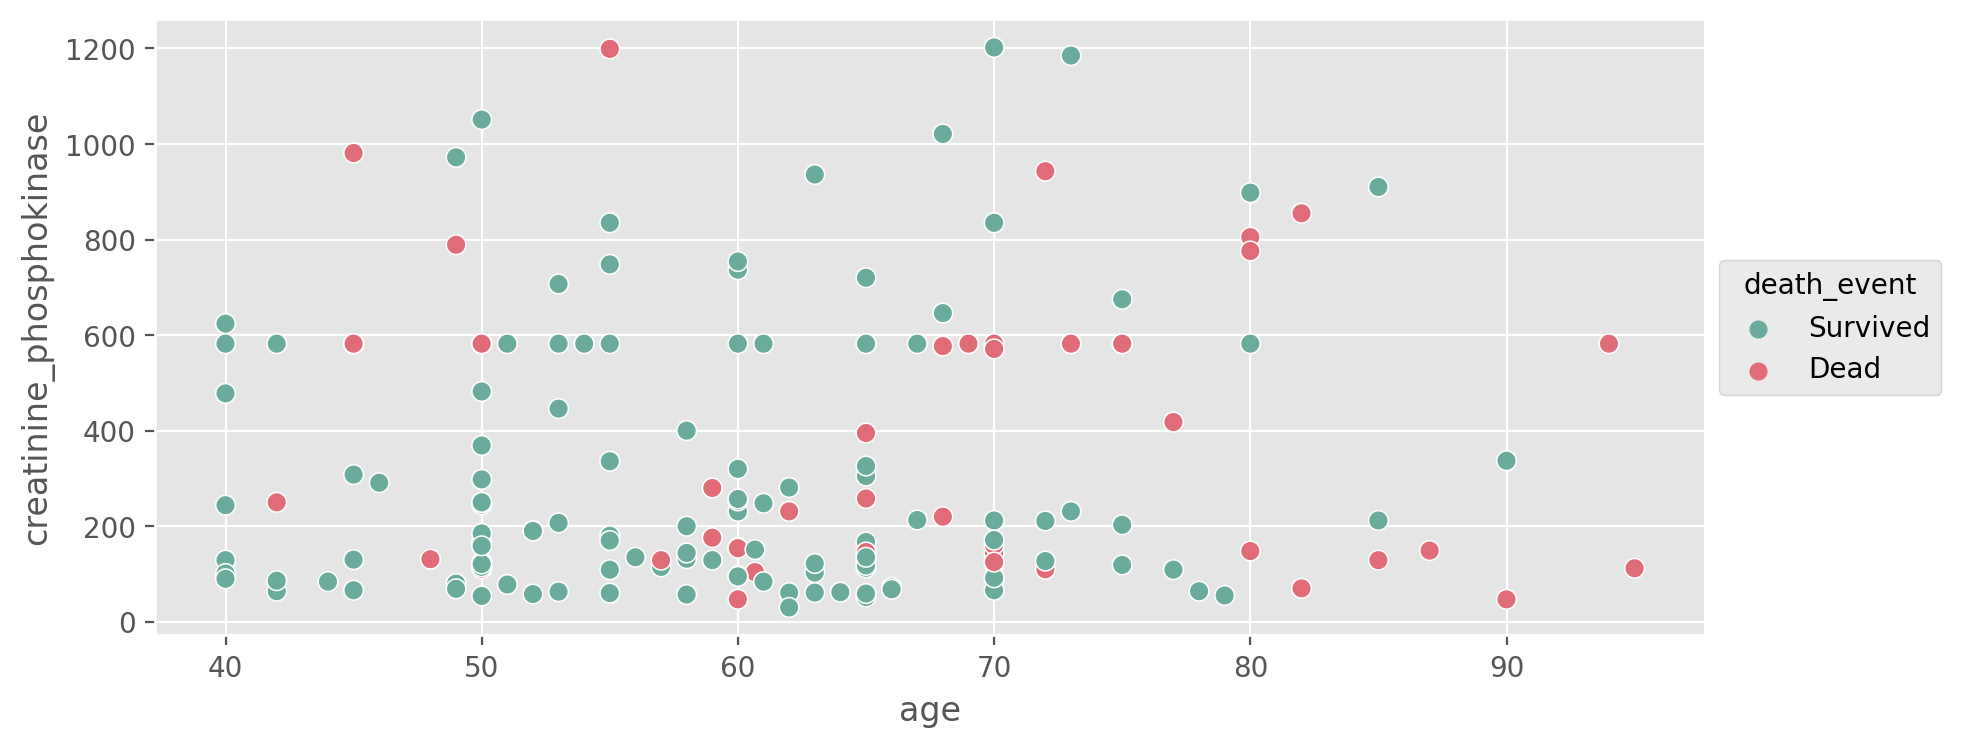

In [21]:
plt.figure(figsize=(10,4),dpi=200)
ax = sns.scatterplot(
    data=pd.concat([X_train,y_train],axis=1),
    x="age",
    y="creatinine_phosphokinase",
    hue="death_event",
    palette=["#6AAB9C","#E06C78"],
    s=50
)
plt.legend(bbox_to_anchor=(1,0.5),loc="center left",title="death_event")

plt.show()

# Conclusion